## Crawling Reviews

In [ ]:
!pip install -qq google-play-scraper

     |████████████████████████████████| 52 kB 1.2 MB/s 


In [ ]:
from google_play_scraper import Sort, reviews

result, continuation_token = reviews(
    'app.bpjs.mobile',
    lang='id', # defaults to 'en'
    country='id', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    count=23000, # defaults to 100
    filter_score_with=None # defaults to None(means all score)
)

result, _ = reviews(
    'app.bpjs.mobile',
    continuation_token=continuation_token # defaults to None(load from the beginning)
)

In [ ]:
import pandas as pd

In [ ]:
import pandas as pd
new_my_dict = result
df = pd.DataFrame.from_dict(new_my_dict) 
df_reviews = df[["content", "score", "at", "reviewCreatedVersion"]]
df_reviews.to_csv('review_content_raw_to_predict.csv', index=False)

## Cleaning Training Reviews

In [ ]:
!pip install Sastrawi

     |████████████████████████████████| 209 kB 5.1 MB/s 


In [ ]:
import pandas as pd
import re
import string
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

class DataCleaning:
  # Initialization
  factory     = StemmerFactory()
  stemmer     = factory.create_stemmer()
  kamus_alay1 = pd.read_csv('https://raw.githubusercontent.com/fendiirfan/Kamus-Alay/main/Kamu-Alay.csv')
  kamus_alay1 = kamus_alay1.set_index('kataAlay')
  kamus_alay2 = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
  kamus_alay2 = kamus_alay2.filter(['slang', 'formal'], axis=1)
  kamus_alay2 = kamus_alay2.drop_duplicates(subset=['slang'], keep='first')
  kamus_alay2 = kamus_alay2.set_index('slang')
  stopword1   = list(pd.read_csv('https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt', header = None)[0])
  custom_word = ['mobile', 'jkn', 'bpjs', 'aplikasi', 'assalamualaikum']

  @classmethod
  def CleanDataFrame(cls, df, col_name, jum_minimum=None, minimum_kata=0):

    final_list_clean = []
    final_list_kotor = []
    ##
    #label = []
    if jum_minimum == None: jum_minimum = len(df)
    if len(df) < jum_minimum: raise "Jumlah Data Yang Diinginkan melebihi Data yang Ada"
    i = 0
    current = 0
    
    while i < len(df):
      current_kalimat = df.loc[i][col_name]
      ##
      #label_kalimat = df.loc[i]['label']
      clean_kalimat = cls.__cleanSentence__(current_kalimat)
      if (len(clean_kalimat.split(' ')) > minimum_kata):
        if (clean_kalimat):
          final_list_clean.append(clean_kalimat)
          final_list_kotor.append(current_kalimat)        
          ##
          #label.append(label_kalimat)
          current += 1
          if current % 10 == 0:
            print("Memproses {} data".format(current))

      if current == jum_minimum:
        break
      i += 1
    
    data = {
        'raw': final_list_kotor,
        'processed': final_list_clean,
        ##
        #'label': label
    }

    return pd.DataFrame(data)

  @classmethod
  def CleanSentence(cls, text):
    return cls.__cleanSentence__(text)

  @classmethod
  def __cleanSentence__(cls, text):
    '''
    Melakukan prapemrosesan pada suatu kalimat dengan menghilangkan formatting pada kalimat,
    menghilangkan stopword pada kalimat, mengganti kata alay yang sudah terdefinisikan, serta
    melakukan stemming kalimat tersebut.
    '''
    print(text)
    # Cleaning Formatted Text using Regex
    text = re.sub(r'http\S+', '', text)
    text = re.sub('(@\w+|#\w+)','',text)
    #will replace the html characters with " "
    text=re.sub('<.*?>', '', text)  
    #To remove the punctuations

    temp_text = list(text)
    for i in range(len(temp_text)):
      if temp_text[i] in string.punctuation:
        temp_text[i] = " "
    text = ''.join(temp_text)

    #will consider only alphabets
    text = re.sub('[^a-zA-Z]',' ',text) 
    #will replace newline with space
    text = re.sub("\n"," ",text)
    #will convert to lower case
    text = text.lower()
    # will replace a word
    text = re.sub("(username|user|url|rt|xf|fx|xe|xa)\s|\s(user|url|rt|xf|fx|xe|xa)","",text)
    # will repalce repated char
    text = re.sub(r'(\w)(\1{2,})', r"\1", text)
    # will replace single word
    text = re.sub(r"\b[a-zA-Z]\b","",text)
    # will replace space more than one
    text = re.sub('(s{2,})',' ',text)
    # will join the words
    text=' '.join(text.split())

    text_split = text.split(' ')
    # Mengganti kata-kata yang tidak baku
    for i in range(len(text_split)):
      if text_split[i] in cls.kamus_alay1.index:
        text_split[i] = cls.kamus_alay1.loc[text_split[i]]['kataBaik']
      elif text_split[i] in cls.kamus_alay2.index:
        text_split[i] = cls.kamus_alay2.loc[text_split[i]]['formal']
      else:
        pass

    # Stemming
    stemmed_text = cls.stemmer.stem(text)

    # Removing Stopwords and custom word
    temp_text_split = []
    for i in range(len(text_split)):
      if (text_split[i] == 'tidak') or (text_split[i] not in cls.stopword1) and (text_split[i] not in cls.custom_word) and (type(text_split[i]) == str):
        temp_text_split.append(text_split[i])

    final_text = ' '.join(temp_text_split)
    
    return final_text

In [ ]:
df = pd.read_csv('/content/MjknReview_5_labeled_2020.csv', delimiter=';')

df_temp = DataCleaning.CleanDataFrame(df, 'content', None, 0)

Streaming output truncated to the last 5000 lines.
Baru juga download tidak bisa di pakai
Bagus
Baru instal,minta upgrade š¤¦ā€¨ā™‚ļø¸
haduh ini aplikasi kenapa siš‘ˇš‘ˇ
Login dan buat akun tidak berhasil
Bermanfaat
Memproses 8930 data
Mantap
Kenapa tidak dapat diproses terus untuk pendaftaran bpjs mandiri ?
Aplikasi jelek
Anu lah pokoke
Kenapa selalu minta update ya,udah gitu muter2 mulu
š‘¨
Good
Datang ke kantor BPJS kesehatan disuruh daftar atau edit dari aplikasi tapi melihat status pembayaran aja tidak bisa. Aplikasi sering update terus lagi
baru di update..minta diupdate terus
Ini gimana dari tadi belum bisa transaksi minta di tunggu beberapa saat, ini udah nunggu beberapa jam tetep aja gitu... tidak ngerti lagi ini aplikasi!
Bagus aplikasinya
Memproses 8940 data
Sangat inpeksibel
Bagus banget
Sangat membantu
Bagus
jagan terlalu sering di update nanti jadi lobet. bikin emosi peserta.
Bagus
tolong diperbaiki aplikasinya jangan lemot
tolong di perbaiki aplikasinya.. Msak mau lo

In [ ]:
df_temp.to_csv('review2020_labeled_cleaned.csv', index=False)

## Model Naive Bayes

In [ ]:
df_temp = pd.read_csv('/content/review2020_labeled_cleaned.csv')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

X_train, X_test,y_train,y_test = train_test_split(df_temp['processed'],
                                                  df_temp['label'], 
                                                  test_size=0.3, 
                                                  shuffle=True, 
                                                  random_state = 42)

In [ ]:
tf_vectorizer = CountVectorizer()
X_train_tf = tf_vectorizer.fit_transform(X_train)
print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 9391, n_features: 5605


In [ ]:
X_test_tf = tf_vectorizer.transform(X_test)
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 4026, n_features: 5605


In [ ]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predicted = naive_bayes_classifier.predict(X_test_tf)

score1 = metrics.accuracy_score(y_test, predicted)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(y_test, predicted))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predicted))

accuracy:   0.933
              precision    recall  f1-score   support

          -1       0.91      0.97      0.94      2236
           1       0.96      0.89      0.92      1790

    accuracy                           0.93      4026
   macro avg       0.94      0.93      0.93      4026
weighted avg       0.93      0.93      0.93      4026

confusion matrix:
[[2169   67]
 [ 204 1586]]


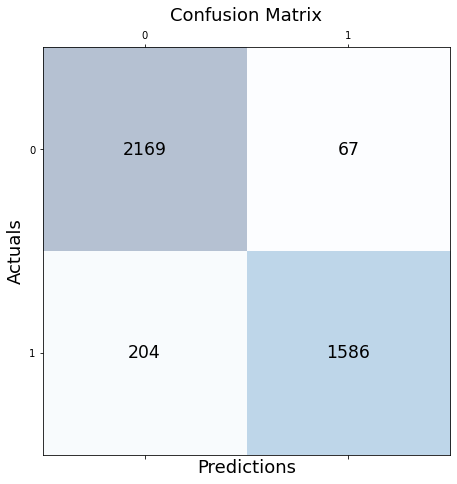

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Cleaning V3 Reviews to Analyze

In [ ]:
df_jkn = pd.read_csv('/content/MjknReview_5_nonlabeled_2021 v3.csv', delimiter=';')

In [ ]:
df_jkn = DataCleaning.CleanDataFrame(df_jkn, 'content', None, 0) 

## Model to V3 Reviews

In [ ]:
X = tf_vectorizer.transform(df_jkn['processed'])
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 7139, n_features: 5605


In [ ]:
predict_fin = naive_bayes_classifier.predict(X)

In [ ]:
df_label_predicted = pd.DataFrame(predict_fin, columns=['label'])
df_label_predicted

,label
0,1
1,-1
2,1
3,-1
4,-1
...,...
7134,1
7135,-1
7136,1
7137,-1


In [ ]:
hasil = pd.concat([df_jkn, df_label_predicted], axis=1)

In [ ]:
hasil.to_csv('Mobilejkn_label_predicted_V3.csv', index=False)

## Analysis

In [ ]:
hasil = pd.read_csv('/content/Mobilejkn_label_predicted_V3.csv')

In [ ]:
hasil.groupby('label').count()

,raw,processed
label,,
-1,4609,4609
1,2530,2530


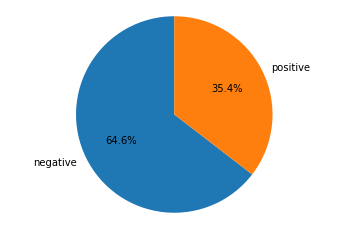

In [ ]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'negative', 'positive'
sizes = [4609, 2530]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color='white')

import matplotlib.pyplot as plt


In [ ]:
hasil_neg

In [ ]:
hasil_neg.reset_index() 

,index,raw,processed,label
0,1,aplikasi yang sangat menyebalkan !!!,menyebalkan,-1
1,3,"kalau bisa walaupun disuruh update,aplikasi jk...",disuruh update dibuka orang tidak update tidak...,-1
2,4,Barang pas di terima sebahagian tidak sesuai h...,barang pas terima sebahagian tidak sesuai harga,-1
3,5,Di upgrade bukan nya mempermudah malah mempers...,upgrade nya mempermudah mempersulit masuk lewa...,-1
4,6,Ini aplikasi setiap mau buka selalu minta upda...,buka meminta update terus,-1
...,...,...,...,...
4604,7130,"Validasi login menyusahkan, karena perangkat s...",validasi login menyusahkan perangkat dipakai l...,-1
4605,7131,di update malah kurang waras,update kurang waras,-1
4606,7132,"Habis diperbarui login ulang,harusnya otomatis,",habis diperbarui login ulang otomatis,-1
4607,7135,"Aplikasi apo ini woy, jgn neman2 nak update, a...",woy neman update lupo nomor beganti masuk inda...,-1


In [ ]:
hasil_neg.iloc[0]['processed']

'menyebalkan'

In [ ]:
temp_word = {}
hasil_neg = hasil.loc[hasil['label'] == -1]
hasil_neg.reset_index()
for i in range(len(hasil_neg)):
  temp_text = hasil_neg.iloc[i]['processed']
  temp_split = temp_text.split(' ')
  temp_set = list(set(temp_split))
  for j in range(len(temp_set)):
    try:
      temp_word[temp_set[j]] += 1
    except:
      temp_word[temp_set[j]] = 1

temp_word_sorted = dict(sorted(temp_word.items(), key=lambda x: x[1], reverse=True))
del temp_word_sorted['tidak']
temp_word_sorted

{'update': 1015,
 'login': 847,
 'terus': 808,
 'daftar': 721,
 'nya': 694,
 'handphone': 617,
 'susah': 613,
 'no': 554,
 'masuk': 512,
 'tolong': 483,
 'untuk': 404,
 'pakai': 389,
 'iya': 385,
 'verifikasi': 382,
 'nomor': 351,
 'banget': 348,
 'kode': 334,
 'baru': 333,
 'jadi': 324,
 'meminta': 321,
 'sih': 286,
 'aplikasinya': 281,
 'ribet': 281,
 'tetap': 264,
 'benar': 259,
 'email': 244,
 'mohon': 242,
 'coba': 235,
 'data': 230,
 'suruh': 224,
 'salah': 220,
 'buka': 216,
 'pas': 207,
 'perbaiki': 206,
 'log': 205,
 'ganti': 204,
 'pulsa': 204,
 'kali': 199,
 'terdaftar': 198,
 'lupa': 186,
 'gagal': 185,
 'masukkan': 178,
 'nomer': 177,
 'versi': 174,
 'word': 174,
 'kartu': 174,
 'otp': 169,
 'eror': 167,
 'jelas': 163,
 'habis': 162,
 'muncul': 159,
 'bagus': 148,
 'bayar': 147,
 'onlen': 144,
 'diperbaiki': 140,
 'sesuai': 136,
 'telepon': 136,
 'lewat': 135,
 'gimana': 135,
 'parah': 130,
 'katanya': 130,
 'faskes': 129,
 'kasih': 128,
 'kirim': 127,
 'pasword': 122,
 'b

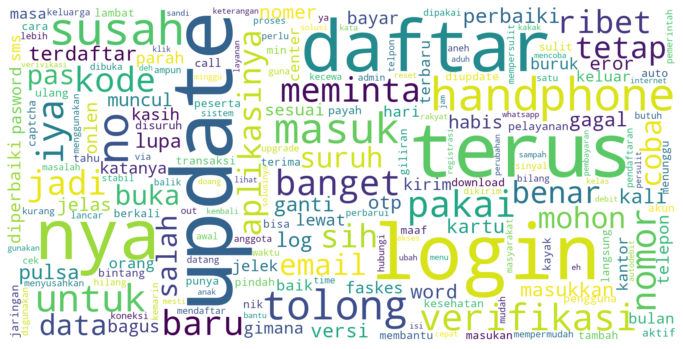

In [ ]:
wordcloud.generate_from_frequencies(temp_word_sorted)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
pos_word = {}
hasil_pos = hasil.loc[hasil['label'] == 1]
hasil_pos.reset_index()
for i in range(len(hasil_pos)):
  temp_text = hasil_pos.iloc[i]['processed']
  temp_split = temp_text.split(' ')
  temp_set = list(set(temp_split))
  for j in range(len(temp_set)):
    try:
      pos_word[temp_set[j]] += 1
    except:
      pos_word[temp_set[j]] = 1

pos_word_sorted = dict(sorted(pos_word.items(), key=lambda x: x[1], reverse=True))
del pos_word_sorted['tidak']
pos_word_sorted

{'membantu': 506,
 'bagus': 381,
 'ok': 326,
 'mantap': 233,
 'good': 172,
 'kasih': 151,
 'baik': 146,
 'terima': 138,
 'mudah': 95,
 'bermanfaat': 95,
 'untuk': 93,
 'pelayanan': 76,
 'kesehatan': 67,
 'oke': 63,
 'semoga': 55,
 'nya': 53,
 'memudahkan': 48,
 'banget': 45,
 'cukup': 44,
 'aplikasinya': 39,
 'informasi': 35,
 'cepat': 34,
 'mempermudah': 33,
 'lumayan': 32,
 'peserta': 31,
 'keren': 31,
 'top': 30,
 'kartu': 30,
 'memuaskan': 29,
 'faskes': 29,
 'perlu': 27,
 'sip': 26,
 'puas': 25,
 'kantor': 25,
 'jadi': 25,
 'terus': 23,
 'mantab': 23,
 'mantul': 23,
 'praktis': 21,
 'masyarakat': 20,
 'alhamdulillah': 20,
 'akses': 20,
 'iya': 19,
 'layanan': 18,
 'mohon': 18,
 'data': 17,
 'keluarga': 16,
 'baru': 15,
 'cek': 15,
 'terbantu': 15,
 'kis': 15,
 'berguna': 15,
 'tingkatkan': 14,
 'lancar': 14,
 'pandemi': 14,
 'cara': 14,
 'onlen': 14,
 'update': 14,
 'pakai': 14,
 'menjadi': 13,
 'jos': 13,
 'kemudahan': 12,
 'lengkap': 12,
 'pindah': 12,
 'berobat': 12,
 'fitur': 

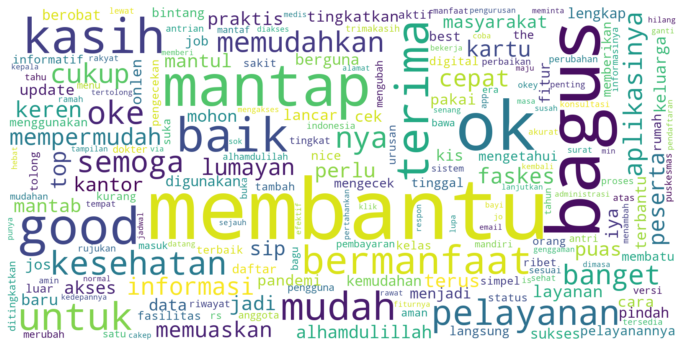

In [ ]:
wordcloud.generate_from_frequencies(pos_word_sorted)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()